# Calibration notebook

About this notebook, we've divided it into the 4 following parts:

1. **Predictions loading**: We load a CSV file with the predictions concerning the model to evaluate.
2. **Evaluations loading**: We load a CSV file with the evaluations concerning the model to evaluate.
3. **Calibrator fit**: After specifying the target measure of interest (e.g., f1-score, accuracy), we fit some calibration models to the transformed predictions using the aforementioned predictions. This introduces some limitations in terms of the granularity of the metrics -- are we fitting it into a discrete/categorical or continuous variable?
5. **Dump calibrated predictions** and **model**: After fitting the model we store the model checkpoint as well as its predictions in the specified folders.


**Note**: We assume that all of these files will have a set of index columns through which we can jointly align them.


In [1]:
OUTPUT_DIR = "../outputs"

# name of the dataset to preprocess
DATASET_NAME, SPLIT_NAME = "squad", "validation"
# DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
# DATASET_NAME, SPLIT_NAME = "narrativeqa", "test_5k_sample_seed_2022"


IS_LOCAL_FS_DATASET = True \
    if (DATASET_NAME in ("newsqa", ) or SPLIT_NAME in ("test_5k_sample_seed_2022",)) \
    else False

if isinstance(DATASET_NAME, tuple):
    NORMALIZED_DATASET_NAME = "".join(DATASET_NAME)
else:
    NORMALIZED_DATASET_NAME = DATASET_NAME
    
# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------
BASE_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}"
ROOT_DIR = f"{OUTPUT_DIR}/results/{NORMALIZED_DATASET_NAME}/{SPLIT_NAME}"

CALIB_ROOT_DIR = f"{ROOT_DIR}/calib"

# ---------------------------------------------------------------------------
# 
# ---------------------------------------------------------------------------

# Arguments used to read the files from disk
csv_kwargs = {
   "compression": "gzip",
   "encoding": "utf-8",
}
    
# ---------------------------------------------------------------------------
# Data columns
# ---------------------------------------------------------------------------
ID_COLS = ["example_id", "answer_id"]
UNIQUE_ID_COL = ID_COLS[0]

## (optional) Split the matrix in calibration and test set

If you dont need this step, feel free to skip this section.

In [2]:
from sklearn.model_selection import train_test_split

import pandas as pd

In [3]:
SPLIT_SEED = 9182
HOLDOUT_FRACTION = 0.5 

# --------------------------------------------------------------------------------
# Original matrices that we're departing to create the two sets for calibration:
# --------------------------------------------------------------------------------
PREDS_DIR = f"{ROOT_DIR}/preds"
PREDS_FILENAME = f"{NORMALIZED_DATASET_NAME}_{SPLIT_NAME}_scores"
PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}_{PREDS_FILENAME}.csv.gz"
# PREDS_FILEPATH = f"{PREDS_DIR}/{BASE_FILENAME}" + f"_{DATASET_NAME}_{SPLIT_NAME}.csv.gz"
#^Note: Typically we'll want the version of the predictions file that has the
# different normalization scores (identified by suffix "_scores")

EVALS_TOKENIZER = "default"
EVALS_DIR = f"{ROOT_DIR}/evals"
EVALS_FILENAME = f"{BASE_FILENAME}_evals_{EVALS_TOKENIZER}"
EVALS_FILEPATH = f"{EVALS_DIR}/{EVALS_FILENAME}.csv.gz"

preds = pd.read_csv(PREDS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)
evals = pd.read_csv(EVALS_FILEPATH, **csv_kwargs).set_index(UNIQUE_ID_COL)

print(len(preds), len(evals))
# In the future we may have dimension mismatch between the evals and preds
# (e.g., multiple beams) requiring some joining process. For now, keeping things
# simple, we'll create the splits based on the UNIQUE_ID_COL to ensure there is
# **no label leakage**, i.e., since the prediction is the same for multiple answer
# pairs, naively sampling them would cause our estimates in the test set to be
# optimistic and not representative of what's going on.
common_examples = preds.index.intersection(evals.index)

calibration_set, test_set = train_test_split(
    common_examples, test_size=HOLDOUT_FRACTION, random_state=SPLIT_SEED)
print("Calibration set size:", len(calibration_set), "\tTest set size:", len(test_set))

calib_preds, calib_evals = preds.loc[calibration_set,:], evals.loc[calibration_set,:]
test_preds, test_evals = preds.loc[test_set,:], evals.loc[test_set,:]

# Sanity check that we have the same exact columns in both sets
assert all([c_col == t_col for c_col, t_col in zip(calib_preds.columns, test_preds.columns)])
assert all([c_col == t_col for c_col, t_col in zip(calib_evals.columns, test_evals.columns)])

10570 18005
Calibration set size: 5282 	Test set size: 5283


We will now write these to a new directory under `{CALIB_DIR}/matrix` not to be mixed with the original dataset preprocessed matrices.

In [4]:
CALIBRATION_MATRIX_DIR = f"{CALIB_ROOT_DIR}/matrix"
!mkdir -p {CALIBRATION_MATRIX_DIR}

# Create trainin set predictions
calib_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz", **csv_kwargs)
test_preds.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz", **csv_kwargs)

calib_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz", **csv_kwargs)
test_evals.to_csv(f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz", **csv_kwargs)

## Fit calibration

In [5]:
import pandas as pd
import numpy as np


def get_dataset_for_calibration(preds_path, evals_path, id_cols, features=None, target=None, **csv_kwargs):
    print("Loading predictions from", preds_path)
    print("Loading evaluation metrics from", evals_path)
    
    preds = pd.read_csv(preds_path, **csv_kwargs).set_index(id_cols)
    evals = pd.read_csv(evals_path, **csv_kwargs).set_index(id_cols)
    _evals_cols = [ecol for ecol in evals.columns if ecol not in preds.columns]
    evals = evals[_evals_cols]
    # Even though we have an evaluation for each instance in the dataset
    # the predictions are not duplicated across different data points
    # hence requiring some filtering to make the two matrices of the same size.
    evals  = preds.join(evals, how="left")[_evals_cols]
    assert len(preds) == len(evals)
    
    
    print("Considering features:", features)
    print("Considering target:", target)
    
    if target and features:
        return preds[features], evals[target]
    else:
        return preds, evals

### Calibration inputs

In [6]:
TRAIN_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{PREDS_FILENAME}.csv.gz"
TEST_SET_PREDS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{PREDS_FILENAME}.csv.gz"

TRAIN_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/train_{EVALS_FILENAME}.csv.gz"
TEST_SET_EVALS_FILEPATH = f"{CALIBRATION_MATRIX_DIR}/test_{EVALS_FILENAME}.csv.gz"

# The name of the feature in the target that we're trying to calibrate towards
UNCALIBRATED_SCORE_COLS = [
    "score_proba",
    "score_proba_arithm",
    "score_proba_geom",
    "score_proba_hmean",
    "score_proba_std",
]

# The metric we're calibrating w.r.t.
CALIBRATION_TARGET = "f1_score"

ID_COLS = ["example_id", "answer_id"]

## Predictions & Evaluations loading

In [7]:
X_train, y_train = get_dataset_for_calibration(
    TRAIN_SET_PREDS_FILEPATH, TRAIN_SET_EVALS_FILEPATH, 
    features=UNCALIBRATED_SCORE_COLS,
    target=CALIBRATION_TARGET,
    id_cols=ID_COLS,
    **csv_kwargs,
)

Loading predictions from ../outputs/results/squad/validation/calib/matrix/train_squad_validation_scores.csv.gz
Loading evaluation metrics from ../outputs/results/squad/validation/calib/matrix/train_squad_validation_evals_default.csv.gz
Considering features: ['score_proba', 'score_proba_arithm', 'score_proba_geom', 'score_proba_hmean', 'score_proba_std']
Considering target: f1_score


In [8]:
X_train.head()

,,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
example_id,answer_id,,,,,
5730a4d02461fd1900a9cf2d,0161a90eee8ce52e8c7e722f0b7e4da0,0.567276,0.876750,0.867858,0.858546,0.121357
57274a8ff1498d1400e8f5be,f0de9c9a28502de1fbc1494ff90e10b4,0.239398,0.780749,0.751319,0.721678,0.208166
572ffee1947a6a140053cf16,b3bdcc3e2b497e486c7e3b708edd6586,0.844184,0.947907,0.945103,0.942202,0.071548
572800b03acd2414000df1f5,254f01ca1c3376e30ebd43a07c36aac4,0.329943,0.833238,0.801102,0.761372,0.203561
572735a15951b619008f86c2,1f97c3592272655a641a348e9a17d4ba,0.200765,0.865253,0.795031,0.680386,0.257627


## Calibration methods

In this section, we're running logistic regression calibration and beta regression calibration techniques to fit a monotonic curve to map from the provided data to the specified one.

In [9]:
import matplotlib.pyplot as plt
import ml_insights as mli

import seaborn as sns

About the plot:
- Length of the acceptance intervals gets larger as we have less data points.
- Ideal: have good calibration across all areas -- (awful result is to have good calibration in rare regions).
- If too little data - may consider merging bins. I'm not confident that this will is useful for NLP in practice.

In [10]:
mli_reliability_kwargs = {
    "ax1_y_title": f"true {CALIBRATION_TARGET}",
    "error_bars": False,
    "show_histogram": True,
}

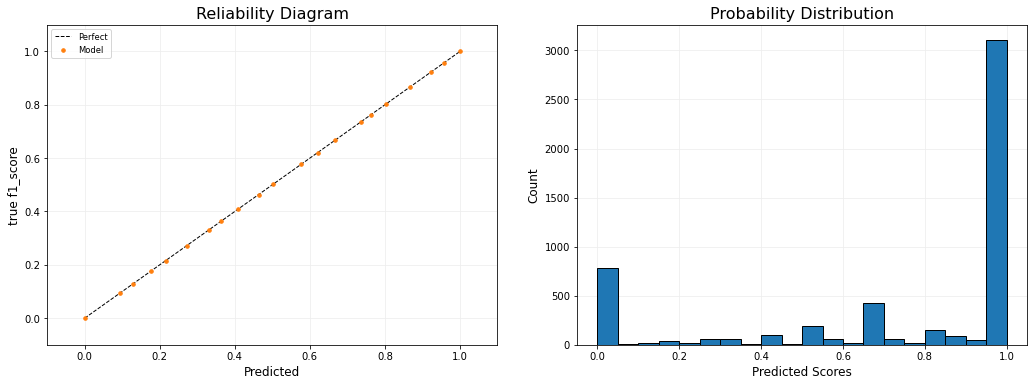

In [11]:
# Distribution of the f1 scores
plt.figure(figsize=(15, 6)); mli.plot_reliability_diagram(y=y_train, x=y_train, **mli_reliability_kwargs);

###  Before calibration

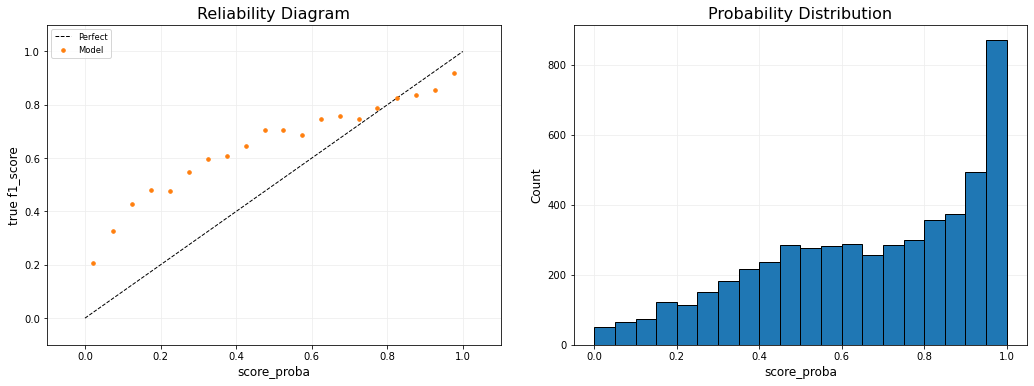

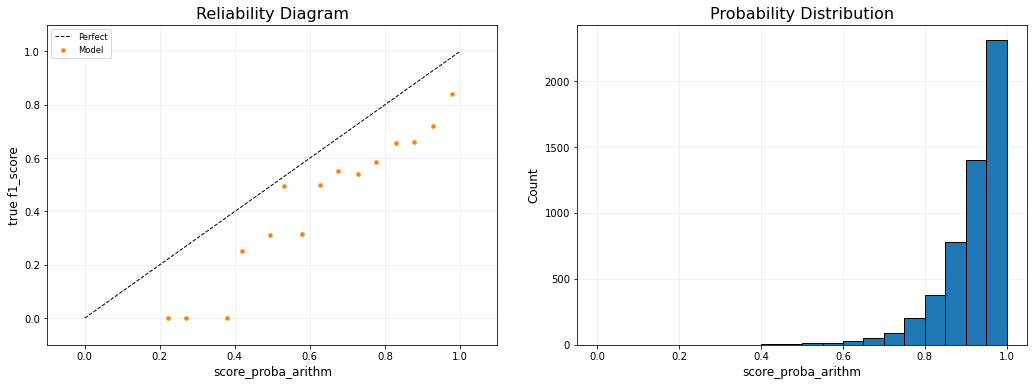

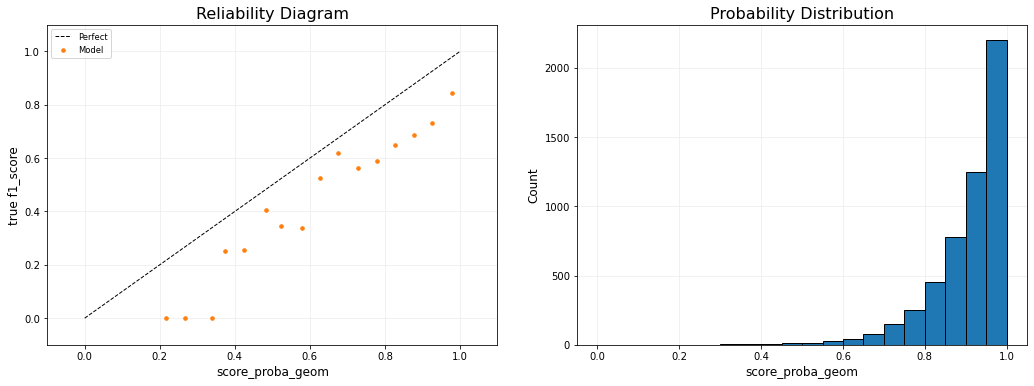

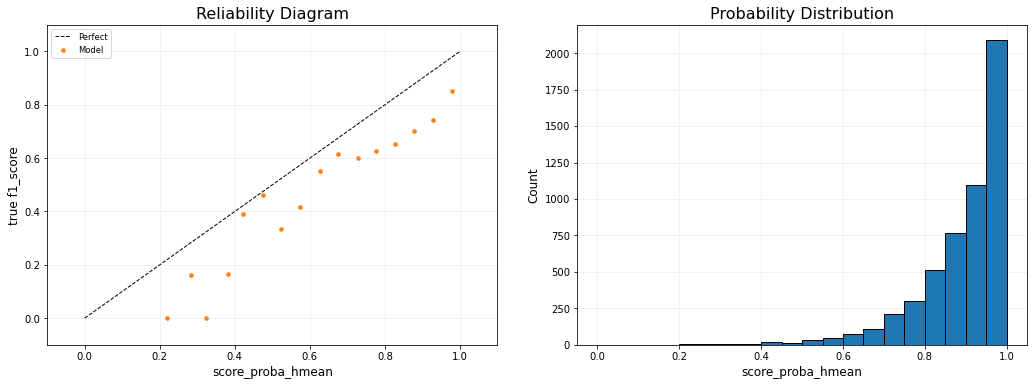

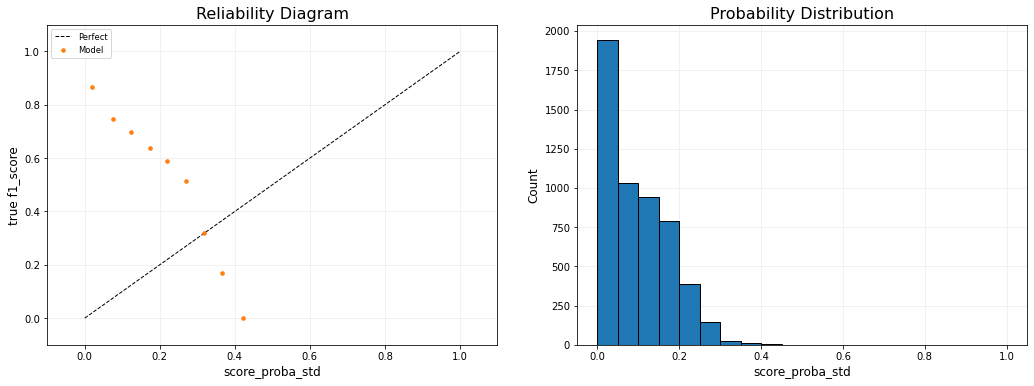

In [12]:
for col in UNCALIBRATED_SCORE_COLS:
    col_kwargs = mli_reliability_kwargs.copy()
    col_kwargs.update({
        "ax1_y_title": f"true {CALIBRATION_TARGET}",
        "ax1_x_title": f"{col}",
        "ax2_x_title": f"{col}",
    })
    # Uncalibrated and calibrated values
    x = X_train[col]
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(y=y_train, x=x, **col_kwargs);

### Logistic Regression (continuous version) w/ MSE

In [13]:
def fit_model(X, y, col, target, model_classpath, model_hyperparams, figname=None):
    model = model_classpath(**model_hyperparams)
    
    # assert len(X.shape) == 1 and len(y.shape) == 1, "This is a 1-d logistic fit"
    model.fit(X, y)
    
    # -------------------------------------------------------------------
    # Observe the fit
    # -------------------------------------------------------------------
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    g = sns.jointplot(x=X, y=y)
    g.ax_joint.set_xlabel(col)
    g.ax_joint.set_ylabel(target)
    # Plot decision boundary
    tvec = np.linspace(.01, .99, 99)
    sns.lineplot(tvec, model.predict(tvec), color="orange", ax=g.ax_joint, label=target);
    
    if figname:
        jointplot = f"{figname}_jointplot.svg"
        plt.savefig(jointplot, dpi=300)
        print("Saved figure at", jointplot)
    
    # -------------------------------------------------------------------
    # Reliability diagram
    # -------------------------------------------------------------------
    y_pred = model.predict(X)
    
    # Distribution of `target` in function of X
    plt.figure(figsize=(15, 6));
    mli.plot_reliability_diagram(
        y=y, 
        x=y_pred, 
        ax1_x_title=f"predicted {target} ({col})",
        ax1_y_title=f"actual {target}",
        ax2_x_title=f"predicted {target} ({col})",
        error_bars=False, show_histogram=True,
    )

    if figname:
        rli = f"{figname}_reliability.svg"
        plt.savefig(rli, dpi=300)
        print("Saved figure at", rli)

    return model, y_pred

/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed_jointplot.svg
Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_arithm_f1_score_a2125102c07cf8dd03a40bb6539cee27_jointplot.svg
Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_arithm_f1_score_a2125102c07cf8dd03a40bb6539cee27_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_geom_f1_score_5743f88591d0ff24484c8a204469cc7c_jointplot.svg
Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_geom_f1_score_5743f88591d0ff24484c8a204469cc7c_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_hmean_f1_score_787af6cfda0f250c6ca19b267859fbd0_jointplot.svg
Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_hmean_f1_score_787af6cfda0f250c6ca19b267859fbd0_reliability.svg


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_std_f1_score_a662042711c5473f9c289d62b4ed90b8_jointplot.svg
Saved figure at ../outputs/results/squad/validation/calib/logistic_mse_train_score_proba_std_f1_score_a662042711c5473f9c289d62b4ed90b8_reliability.svg


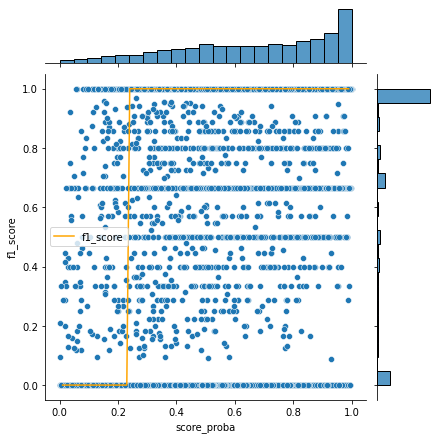

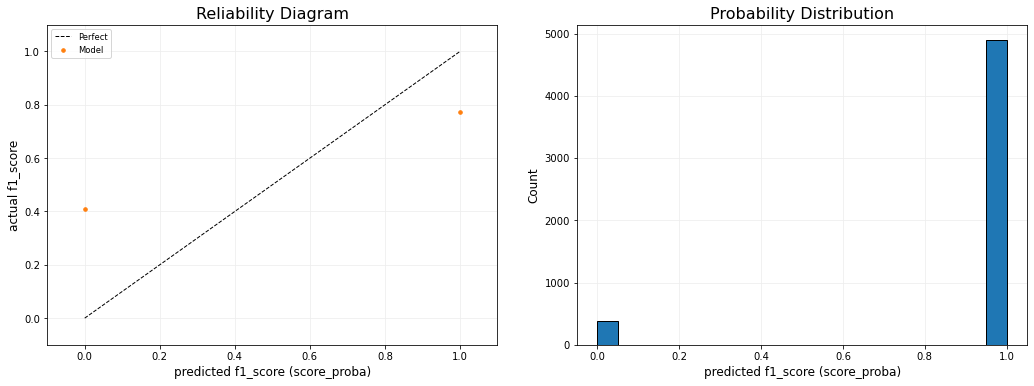

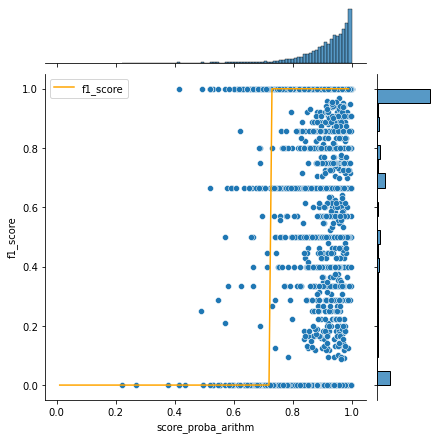

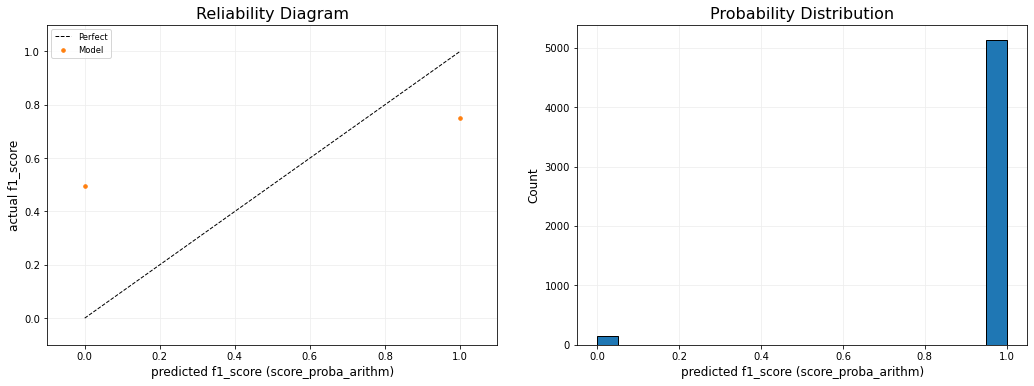

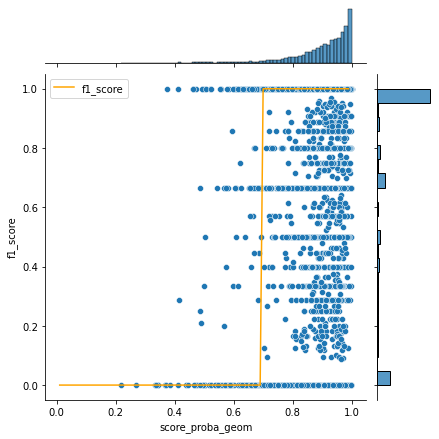

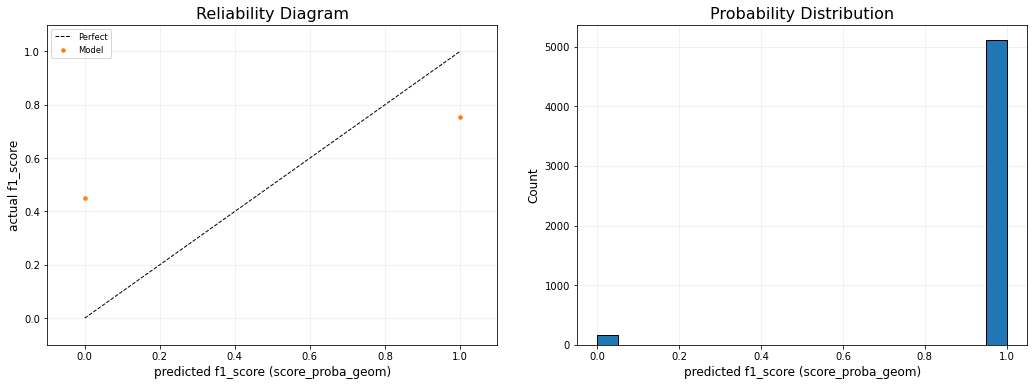

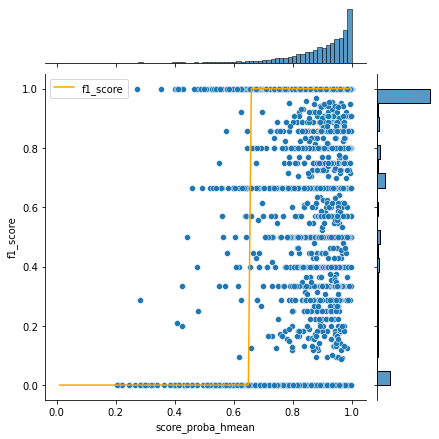

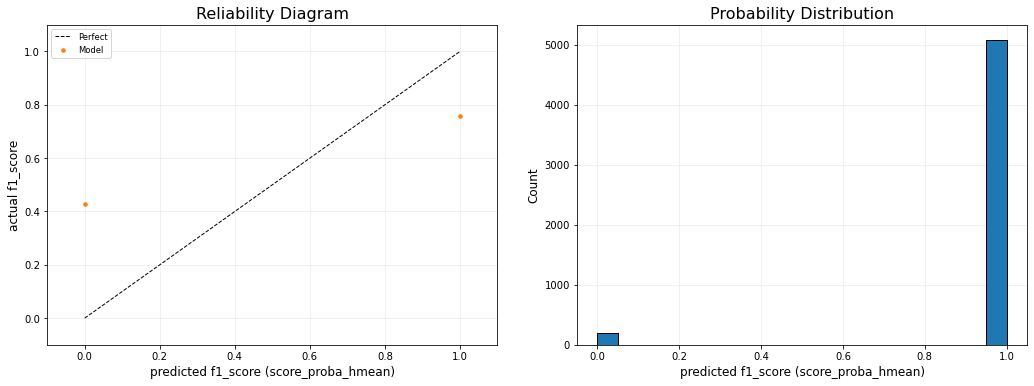

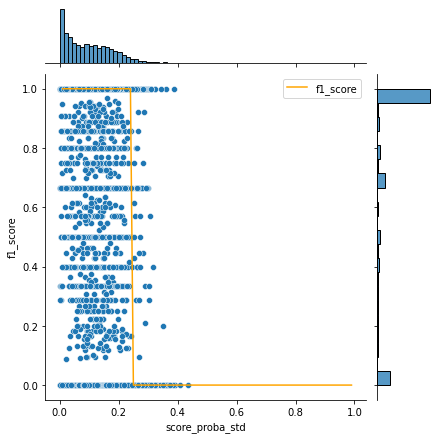

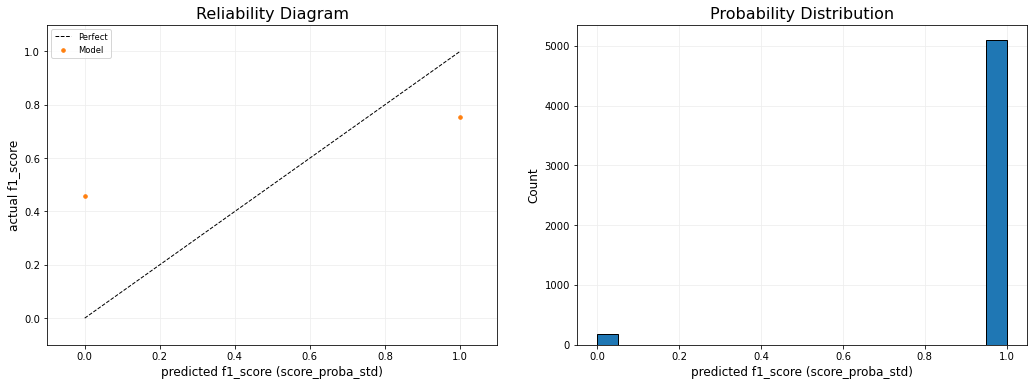

In [14]:
from functools import partial
from logistic import LogisticRegression
from utils_generic import method_name, generate_uuid

model_classpath = LogisticRegression
model_hyperparams = {}

# -------------------------------------------------------------------
#
# Fit LOGISTIC REGRESSION
# 
# -------------------------------------------------------------------
fit_logistic = partial(
    fit_model,
    model_classpath=model_classpath,
    model_hyperparams=model_hyperparams,
    target=CALIBRATION_TARGET,
)

results_metadata = {}
results_model = {}
results_preds = {}
for col in UNCALIBRATED_SCORE_COLS:
    features = sorted([col])
    
    calibrator_metadata = {
        "dataset_name": NORMALIZED_DATASET_NAME,
        "split_name": SPLIT_NAME,
        "preds_train_path": TRAIN_SET_PREDS_FILEPATH,
        "evals_train_path": TRAIN_SET_EVALS_FILEPATH,
        "model_classpath": method_name(model_classpath),
        "model_hyperparameters": model_hyperparams,
        "features": features,
        "features_uuid": generate_uuid(features),
        "target_metric": CALIBRATION_TARGET,
    }
    
    calibrator_uuid = generate_uuid(calibrator_metadata)
    calibrator_metadata["calibrator_uuid"] = calibrator_uuid
    
    name = f"logistic_mse_train_{col}_{CALIBRATION_TARGET}_{calibrator_uuid}"
    calibrator_metadata["name"] = name
    
    calibrator_figname = f"{CALIB_ROOT_DIR}/{name}"
    calibrator_metadata["calibrator_figname"] = calibrator_figname
    # Uncalibrated and calibrated values
    X = X_train[features].values.flatten()
    y = y_train.values.copy().flatten()
    
    # We re-use the same structure as the preds we've loaded initially
    # write them into a calibrated predictions file.
    model, preds = fit_logistic(X=X, y=y, col=col, figname=calibrator_figname)
    
    results_model[col] = model
    results_preds[col] = preds
    results_metadata[col] = calibrator_metadata

#### Store model and calibrated predictions

In [15]:
from utils_generic import generate_uuid

import joblib
import yaml
import os


def store_calibration_results(parent_dir, data, preds: dict, models: dict, metadata: dict):
    preds_ext = ".csv.gz"
    model_ext = ".joblib"
    metadata_ext = "metadata.yaml"
    
    os.makedirs(f"{parent_dir}/preds", exist_ok=True)
    os.makedirs(f"{parent_dir}/models", exist_ok=True)
    
    keys = preds.keys()
    for key in keys:
        pred_key = preds[key]
        model_key = models[key]
        metadata_key = metadata[key]
        
        d = data.copy()
        d[key] = pred_key
        
        key_name = metadata_key["name"]
        preds_filepath = f"{parent_dir}/preds/{key_name}{preds_ext}"
        print("\nStoring predictions for", key_name, "with columns:", d.columns, "at", preds_filepath)
        d.to_csv(preds_filepath)
        
        model_filepath = f"{parent_dir}/models/{key_name}"
        print("\nStoring model pickle and meatadata for", key_name, "at", model_filepath)
        joblib.dump(model_key, model_filepath + model_ext)

        with open(model_filepath + metadata_ext, "w") as f:
            yaml.dump(metadata_key, f)
            
            
# Sanity check
store_calibration_results(
    CALIB_ROOT_DIR,
    data=pd.DataFrame(y_train),
    preds=results_preds,
    models=results_model,
    metadata=results_metadata,
 )


Storing predictions for logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed with columns: Index(['f1_score', 'score_proba'], dtype='object') at ../outputs/results/squad/validation/calib/preds/logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed.csv.gz

Storing model pickle and meatadata for logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed at ../outputs/results/squad/validation/calib/models/logistic_mse_train_score_proba_f1_score_94ad58c0ffb58a19d4e561f1f464b7ed

Storing predictions for logistic_mse_train_score_proba_arithm_f1_score_a2125102c07cf8dd03a40bb6539cee27 with columns: Index(['f1_score', 'score_proba_arithm'], dtype='object') at ../outputs/results/squad/validation/calib/preds/logistic_mse_train_score_proba_arithm_f1_score_a2125102c07cf8dd03a40bb6539cee27.csv.gz

Storing model pickle and meatadata for logistic_mse_train_score_proba_arithm_f1_score_a2125102c07cf8dd03a40bb6539cee27 at ../outputs/results/squad/valid

## Compute `Evals` in training


In [16]:
CALIB_EVALS_DIR = f"{CALIB_ROOT_DIR}/evals"
os.makedirs(CALIB_EVALS_DIR, exist_ok=True)


# Metrics to compute
CORR_METRICS_SUFFIX = "correlation_metrics"
CALIB_METRICS_SUFFIX = "calibration_metrics"
# ---------------------------------------------------------------------------------------------------
# 
# These files will contain the metrics concerning the different calibration techniques applied!
# 
# ---------------------------------------------------------------------------------------------------
# Name of the filepath to output the correlation metrics to
CALIBRATOR_TRAIN_CORR_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CORR_METRICS_SUFFIX}.csv"

# Name of the filepath to output the calibration metrics to
CALIBRATOR_TRAIN_CALIB_METRICS = f"{CALIB_EVALS_DIR}/train_{BASE_FILENAME}_{CALIB_METRICS_SUFFIX}.csv"

!ls {CALIB_EVALS_DIR}

train_squad_validation_calibration_metrics.csv
train_squad_validation_correlation_metrics.csv



Just for a quick sanity check, the predicted distribution should be closer to the target metric `CALIBRATION_TARGET`, especially around the mean, since we're using the MSE (and the predictive mean is known to be the minimizer of the MSE).

- We note that the true distribution (`y_train`) has higher variance.
- Regardless of normalization scores, every distribution approximates the `mean`.
- None of these distributions is able to model values all way up to 1, i.e., maximum prediction is always below 1 (how will this affect user's confidence?, how is it compared with the OOD results?)

In [17]:
calibration_preds_df = pd.DataFrame(results_preds)
#calibration_preds_df[CALIBRATION_TARGET] = y_train.values
calibration_preds_df.index = X_train.index
pd.concat((calibration_preds_df, y_train), axis=1, names=list(calibration_preds_df.columns) + [CALIBRATION_TARGET]).describe()

,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std,f1_score
count,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.926732,0.971412,0.967437,0.961568,0.964975,0.744901
std,0.260600,0.166660,0.177508,0.192256,0.183859,0.369950
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,1.000000,1.000000,0.571429
50%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [18]:
TRAIN_SET_EVALS_FILEPATH

'../outputs/results/squad/validation/calib/matrix/train_squad_validation_evals_default.csv.gz'

In [19]:
# Calibration training evals (the metrics file used to retrieve the CALIBRATION_TARGET)
TRAIN_EVALS = pd.read_csv(TRAIN_SET_EVALS_FILEPATH).set_index(ID_COLS)
TRAIN_EVALS.tail()

exact_match  \
example_id               answer_id                                       
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb            1   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7            0   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945            0   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af            0   
                         bc8507e5f1e73ba6df441cb24323d649            1   

                                                           first_error_position  \
example_id               answer_id                                                
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb                   NaN   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7                   0.0   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945                   0.0   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af                   2.0   
                         bc8507e5f1e73ba6df441cb24323d649                   NaN   

                                                           precision  recall  \
example_id               answer_id                                             
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb   1.000000     1.0   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7   0.750000     1.0   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945   0.333333     1.0   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af   0.400000     1.0   
                         bc8507e5f1e73ba6df441cb24323d649   1.000000     1.0   

                                                           f1_score       csi  \
example_id               answer_id                                              
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb  1.000000  1.000000   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7  0.857143  0.750000   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945  0.500000  0.333333   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af  0.571429  0.400000   
                         bc8507e5f1e73ba6df441cb24323d649  1.000000  1.000000   

                                                             rouge1  rouge2  \
example_id               answer_id                                            
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb  1.000000     0.0   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7  0.857143     0.8   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945  0.500000     0.0   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af  0.571429     0.4   
                         bc8507e5f1e73ba6df441cb24323d649  1.000000     1.0   

                                                             rougeL  \
example_id               answer_id                                    
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb  1.000000   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7  0.857143   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945  0.500000   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af  0.571429   
                         bc8507e5f1e73ba6df441cb24323d649  1.000000   

                                                           rougeLsum  ...  \
example_id               answer_id                                    ...   
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb   1.000000  ...   
5727f5622ca10214002d9a47 b8500f9770dba49e286863b895f0eee7   0.857143  ...   
56e777e500c9c71400d77176 6046b6ca098a60f7d2ee1203f7b1f945   0.500000  ...   
572980f9af94a219006aa4d1 b23dd7bda9f64982737cebb1461cb7af   0.571429  ...   
                         bc8507e5f1e73ba6df441cb24323d649   1.000000  ...   

                                                           truncated  \
example_id               answer_id                                     
572967e31d046914007793b2 e9c6fe0ad6efd8bd22a4fb35b98eb2fb          1   
5727f5622ca10214002d9

In [20]:
SCORE_COLS = UNCALIBRATED_SCORE_COLS
evals = TRAIN_EVALS.loc[X_train.index,:]
assert len(evals) == len(calibration_preds_df)

# This cell is copied from the notebook 4
import metrics as m

# Validation of the scores range
for col in SCORE_COLS:
    assert 0 <= min(calibration_preds_df[col]), f"{col} col is less than 0"
    assert max(calibration_preds_df[col]) <= 1, f"{col} col is greater than 1"

# Let us compute the
GLOBAL_METRICS = evals.join(calibration_preds_df, how="left", lsuffix="__DROP#!").filter(regex="^(?!.*__DROP#!)")
GLOBAL_METRICS.head()

,,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,...,truncated,preds_raw_scores,labels_token,preds_token,multi_way_labels_token,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
example_id,answer_id,,,,,,,,,,,,,,,,,,,,,
5730a4d02461fd1900a9cf2d,0161a90eee8ce52e8c7e722f0b7e4da0,1,NaN,1.00,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1,"[0.6929129958152771, 0.9707042574882507, 0.999...",['catholicism'],['catholicism'],[['catholicism']],1,1,1,1,1
57274a8ff1498d1400e8f5be,f0de9c9a28502de1fbc1494ff90e10b4,0,2.0,0.50,1.000000,0.666667,0.500000,0.666667,0.5,0.666667,0.666667,...,1,"[0.5442671775817871, 0.9994813799858093, 0.830...","['very', 'low']","['very', 'low', 'tuition', 'fees']","[['very', 'low'], ['very', 'low', 'tuition', '...",1,1,1,1,1
572ffee1947a6a140053cf16,b3bdcc3e2b497e486c7e3b708edd6586,1,NaN,1.00,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,...,1,"[0.9983171224594116, 0.8467239737510681, 0.998...",['1908'],['1908'],[['1908']],1,1,1,1,1
572800b03acd2414000df1f5,254f01ca1c3376e30ebd43a07c36aac4,1,NaN,1.00,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,...,1,"[0.4462790787220001, 0.9999245405197144, 0.874...","['black', 'guardian', 'trilogy']","['black', 'guardian', 'trilogy']","[['black', 'guardian', 'trilogy']]",1,1,1,1,1
572735a15951b619008f86c2,1f97c3592272655a641a348e9a17d4ba,0,0.0,0.25,0.333333,0.285714,0.166667,0.285714,0.0,0.285714,0.285714,...,1,"[0.2455015331506729, 0.9874624609947205, 0.982...","['abc', 'on', 'demand']","['beginning', 'of', 'abc', 'show']","[['abc', 'on', 'demand'], ['abc', 'on', 'deman...",0,1,1,1,0


In [21]:
REFERENCE_METRICS = [CALIBRATION_TARGET] 

# -----------------------------------------------------------------
GLOBAL_METRICS = GLOBAL_METRICS.reset_index()
print("Before de-duplication of data:", len(GLOBAL_METRICS))

_temp = GLOBAL_METRICS.sort_values(REFERENCE_METRICS, ascending=False)
GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)

print("After de-duplication of data:", len(GLOBAL_METRICS_UNIQUE))
# -----------------------------------------------------------------
GLOBAL_METRICS_UNIQUE.info()

Before de-duplication of data: 5282
After de-duplication of data: 5282
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5282 entries, ('5730a4d02461fd1900a9cf2d', '0161a90eee8ce52e8c7e722f0b7e4da0') to ('572980f9af94a219006aa4d1', 'b23dd7bda9f64982737cebb1461cb7af')
Data columns (total 41 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   exact_match             5282 non-null   int64  
 1   first_error_position    2184 non-null   float64
 2   precision               5282 non-null   float64
 3   recall                  5282 non-null   float64
 4   f1_score                5282 non-null   float64
 5   csi                     5282 non-null   float64
 6   rouge1                  5282 non-null   float64
 7   rouge2                  5282 non-null   float64
 8   rougeL                  5282 non-null   float64
 9   rougeLsum               5282 non-null   float64
 10  meteor                  5282 non-null   float64
 11  bleu 

/tmp/ipykernel_1663894/4102815749.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  GLOBAL_METRICS_UNIQUE = GLOBAL_METRICS[~_temp.duplicated(UNIQUE_ID_COL)].set_index(ID_COLS)


### Correlation metrics

In [22]:
corr_metrics = []
for score_col in SCORE_COLS:
    print(score_col)
    score_col_results = m.CorrelationMetric(score_col).compute(GLOBAL_METRICS_UNIQUE, REFERENCE_METRICS)
    score_col_results = score_col_results.dropna()
    corr_metrics.append(score_col_results)
    
corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
corr_metrics

score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std


,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.256155,6.584816e-80,0.255126,2.924179e-79,0.234824,9.801515e-77,correlation
1,f1_score,score_proba_arithm,0.115715,3.277582e-17,0.100421,2.571827e-13,0.092430,2.928519e-13,correlation
2,f1_score,score_proba_geom,0.145191,2.798469e-26,0.126274,3.202442e-20,0.116225,4.459002e-20,correlation
3,f1_score,score_proba_hmean,0.170411,1.042786e-35,0.149105,1.218352e-27,0.137240,2.335978e-27,correlation
4,f1_score,score_proba_std,0.148642,1.773152e-27,0.129050,4.677129e-21,0.118781,6.715051e-21,correlation


In [23]:
print("Storing correlation metrics at", CALIBRATOR_TRAIN_CORR_METRICS)
corr_metrics.to_csv(f"{CALIBRATOR_TRAIN_CORR_METRICS}", index=False)

Storing correlation metrics at ../outputs/results/squad/validation/calib/evals/train_squad_validation_correlation_metrics.csv


### Calibration metrics


Amongst the calibration metrics, we have `expected calibration error (ECE)`, `brier score`, `AUC` which quantify the absolute and relative calibrations measures. 


In [24]:
CALIB_METRICS = [CALIBRATION_TARGET]

In [25]:
calib_metrics = []
for calib_metric in CALIB_METRICS:
    calib_results = m.CalibrationMetrics(calib_metric).compute(GLOBAL_METRICS_UNIQUE, SCORE_COLS)
    calib_results = calib_results.dropna()
    
    calib_metrics.append(calib_results)
    
calib_metrics = pd.concat(calib_metrics, axis=0)
calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.188417,0.241604,0.181832,0.394151,0.029886,0.029886,0.229213,0.024956,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.201649,0.254835,0.226512,0.387739,0.014162,0.014162,0.226512,0.028020,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.198797,0.251983,0.222536,0.386361,0.014724,0.014724,0.222536,0.026947,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.196501,0.249687,0.216667,0.386725,0.016510,0.016510,0.221748,0.027201,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.198851,0.252037,0.220075,0.387838,0.015981,0.015981,0.221132,0.027518,"{'n_bins': 20, 'frac': 0.1}",calibration


In [26]:
print("Storing calibration metrics at", CALIBRATOR_TRAIN_CALIB_METRICS)
calib_metrics.describe().to_csv(CALIBRATOR_TRAIN_CALIB_METRICS, index=False)

Storing calibration metrics at ../outputs/results/squad/validation/calib/evals/train_squad_validation_calibration_metrics.csv


## Evaluation in `test_set`

In [27]:
def evaluate(X, y, models_dict, target, figname):
    X_data, y_data = X.copy(), y.copy()
    models_preds = {}
    for col, model in models_dict.items():
        print(col, figname)
        X = X_data[col].values.flatten()
        y = y_data.values.flatten()
        assert len(X.shape) == 1 and len(y.shape) == 1, "This is a 1-d logistic fit"

        # -------------------------------------------------------------------
        # Observe the fit
        # -------------------------------------------------------------------
        # We re-use the same structure as the preds we've loaded initially
        # write them into a calibrated predictions file.
        g = sns.jointplot(x=X, y=y)
        g.ax_joint.set_xlabel(col)
        g.ax_joint.set_ylabel(target)
        # Plot decision boundary
        tvec = np.linspace(.01, .99, 99)
        sns.lineplot(tvec, model.predict(tvec), color="orange", ax=g.ax_joint, label=target);

        jointplot = f"{figname}_{col}_jointplot.svg"
        plt.savefig(jointplot, dpi=300)
        print("Saved figure at", jointplot)

        # -------------------------------------------------------------------
        # Reliability diagram
        # -------------------------------------------------------------------
        y_pred = model.predict(X)

        # Distribution of `target` in function of X
        plt.figure(figsize=(15, 6));
        mli.plot_reliability_diagram(
            y=y, 
            x=y_pred, 
            ax1_x_title=f"predicted {target} ({col})",
            ax1_y_title=f"actual {target}",
            ax2_x_title=f"predicted {target} ({col})",
            error_bars=False, show_histogram=True,
        )
        rli = f"{figname}_{col}_reliability.svg"
        plt.savefig(rli, dpi=300)
        print("Saved figure at", rli)
        models_preds[col] = y_pred
        
    return models_preds

In [28]:
def get_path(matrix_type, dataset_name, split_name, tokenizer="default", parent_dir=OUTPUT_DIR):
    assert matrix_type in ("train", "test")
    
    if isinstance(dataset_name, tuple):
        normalized_dataset_name = "".join(DATASET_NAME)
    else:
        normalized_dataset_name = dataset_name
        
    base_filename = f"{normalized_dataset_name}_{split_name}"
    base_dir = f"{parent_dir}/results/{normalized_dataset_name}/{split_name}" 
    
    calib_dir = f"{base_dir}/calib/matrix"
    calib_preds_path = f"{calib_dir}/{matrix_type}_{base_filename}_scores.csv.gz"
    calib_evals_path = f"{calib_dir}/{matrix_type}_{base_filename}_evals_{tokenizer}.csv.gz"
    
    return calib_preds_path, calib_evals_path, f"{matrix_type}_{base_filename}"

In [29]:
# DATASET_NAME, SPLIT_NAME = "squad", "validation"
# DATASET_NAME, SPLIT_NAME = "newsqa", "dev"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'new_wiki'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'nyt'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'amazon'), "test"
# DATASET_NAME, SPLIT_NAME = ('squadshifts', 'reddit'), "test"
DATASETS_SPLITS = [
    ("squad", "validation"),
    ("newsqa", "dev"),
    #  (('squadshifts', 'new_wiki'), "test"),
    ("narrativeqa", "test_5k_sample_seed_2022"),
]


def evaluate_datasets(datasets_splits, matrix_type, models, target):
    for dataset_name, split_name in datasets_splits:
        print("\n\n# -------------------------------------------------------------------------------------------------------------- #")
        print(f"#\t\t\t {NORMALIZED_DATASET_NAME} ({SPLIT_NAME}) ---> {dataset_name} ({split_name})")
        print("# -------------------------------------------------------------------------------------------------------------- #")
        pred_path, eval_path, base_filename = get_path(matrix_type, dataset_name, split_name)

        X, y = get_dataset_for_calibration(
            pred_path, 
            eval_path, 
            id_cols=ID_COLS,
            **csv_kwargs,
        )

        X_train = X[UNCALIBRATED_SCORE_COLS]
        y_train = y[CALIBRATION_TARGET]
        print("Evaluate in training set for dataset:", dataset_name, split_name)
        yield X, y, evaluate(X_train, y_train, models, target=target, figname=base_filename)

        
        
def evaluate_metrics(global_metrics: pd.DataFrame, score_cols: list, target=CALIBRATION_TARGET, id_cols=ID_COLS):
    # Validation of the scores range
    for col in score_cols:
        assert 0 <= min(global_metrics[col]), f"{col} col is less than 0"
        assert max(global_metrics[col]) <= 1, f"{col} col is greater than 1"

    # Let us compute the    
    ref_metrics = [target]
    
    corr_metrics = []
    for score_col in SCORE_COLS:
        print(score_col)
        score_col_results = m.CorrelationMetric(score_col).compute(global_metrics, ref_metrics)
        score_col_results = score_col_results.dropna()
        corr_metrics.append(score_col_results)

    corr_metrics = pd.concat(corr_metrics, axis=0).reset_index(drop=True)
    
    calib_metrics = []
    for calib_metric in ref_metrics:
        calib_results = m.CalibrationMetrics(calib_metric).compute(global_metrics, score_cols)
        calib_results = calib_results.dropna()

        calib_metrics.append(calib_results)

    calib_metrics = pd.concat(calib_metrics, axis=0)

    return corr_metrics, calib_metrics

In [30]:
train_evaluations = evaluate_datasets(DATASETS_SPLITS, matrix_type="train", models=results_model, target=CALIBRATION_TARGET)
test_evaluations = evaluate_datasets(DATASETS_SPLITS, matrix_type="test", models=results_model, target=CALIBRATION_TARGET)

### Train evaluations for 



# -------------------------------------------------------------------------------------------------------------- #
#			 squad (validation) ---> squad (validation)
# -------------------------------------------------------------------------------------------------------------- #
Loading predictions from ../outputs/results/squad/validation/calib/matrix/train_squad_validation_scores.csv.gz
Loading evaluation metrics from ../outputs/results/squad/validation/calib/matrix/train_squad_validation_evals_default.csv.gz
Considering features: None
Considering target: None
Evaluate in training set for dataset: squad validation
score_proba train_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_squad_validation_score_proba_jointplot.svg
Saved figure at train_squad_validation_score_proba_reliability.svg
score_proba_arithm train_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_squad_validation_score_proba_arithm_jointplot.svg
Saved figure at train_squad_validation_score_proba_arithm_reliability.svg
score_proba_geom train_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_squad_validation_score_proba_geom_jointplot.svg
Saved figure at train_squad_validation_score_proba_geom_reliability.svg
score_proba_hmean train_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_squad_validation_score_proba_hmean_jointplot.svg
Saved figure at train_squad_validation_score_proba_hmean_reliability.svg
score_proba_std train_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at train_squad_validation_score_proba_std_jointplot.svg
Saved figure at train_squad_validation_score_proba_std_reliability.svg
score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std
score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std


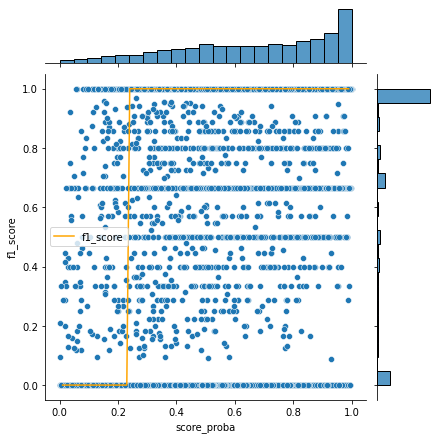

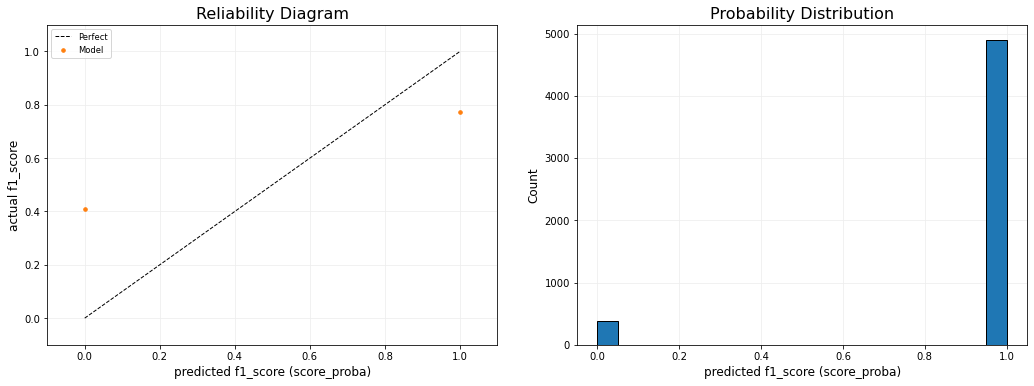

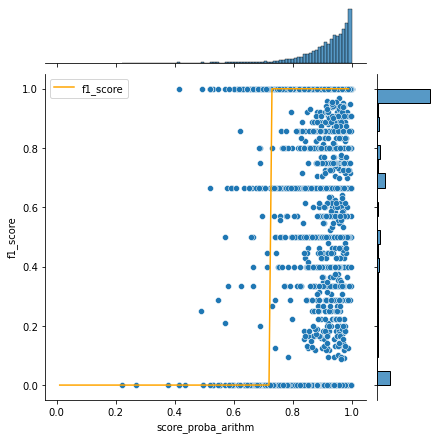

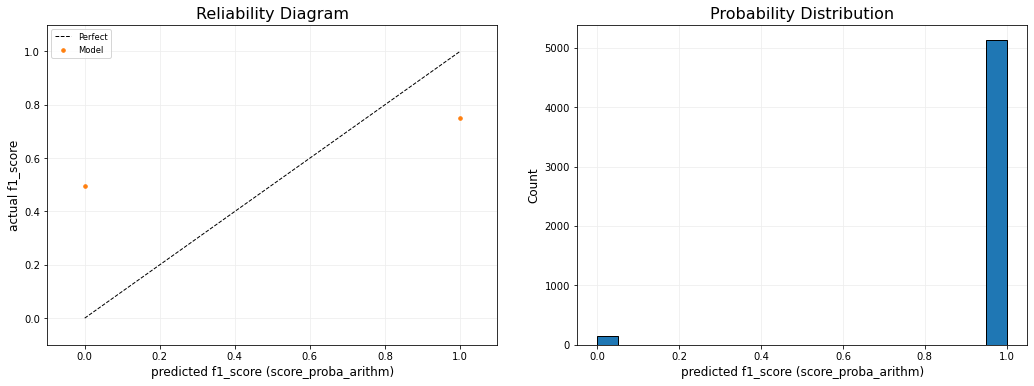

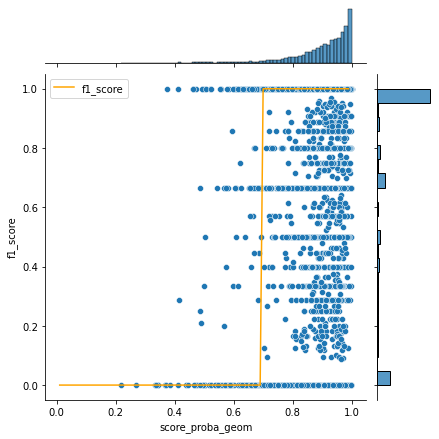

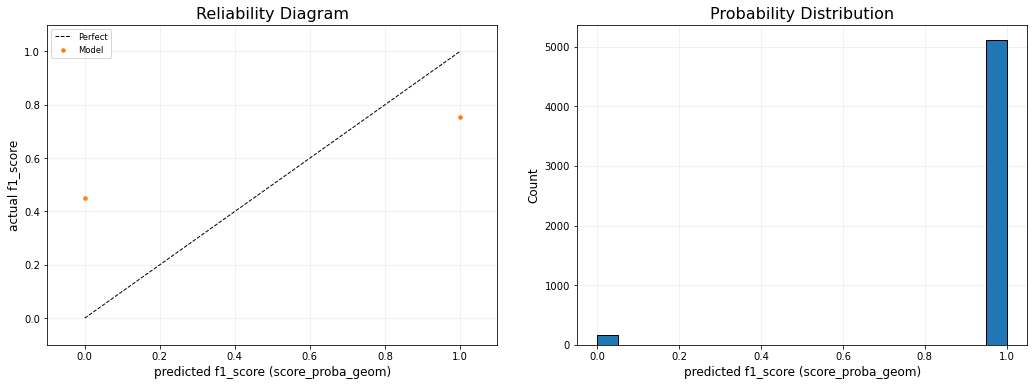

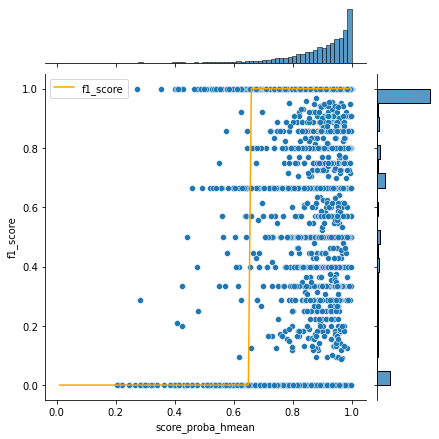

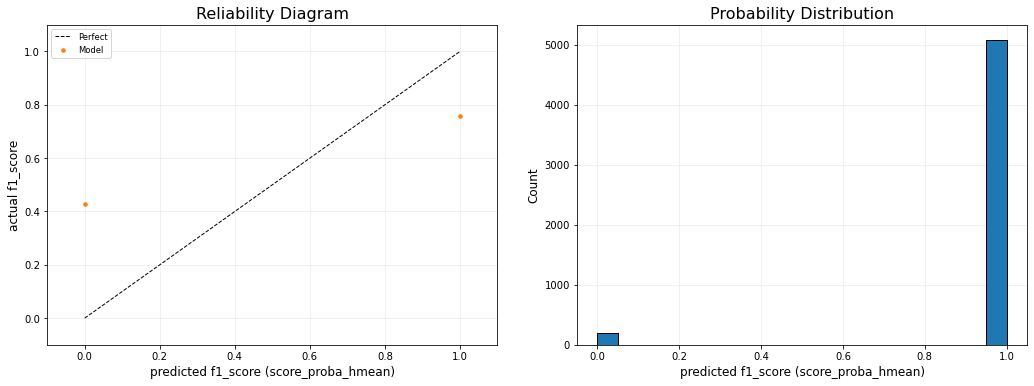

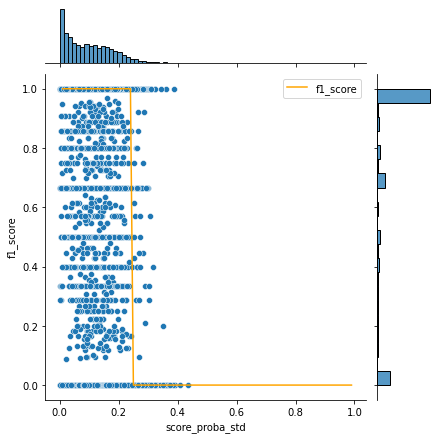

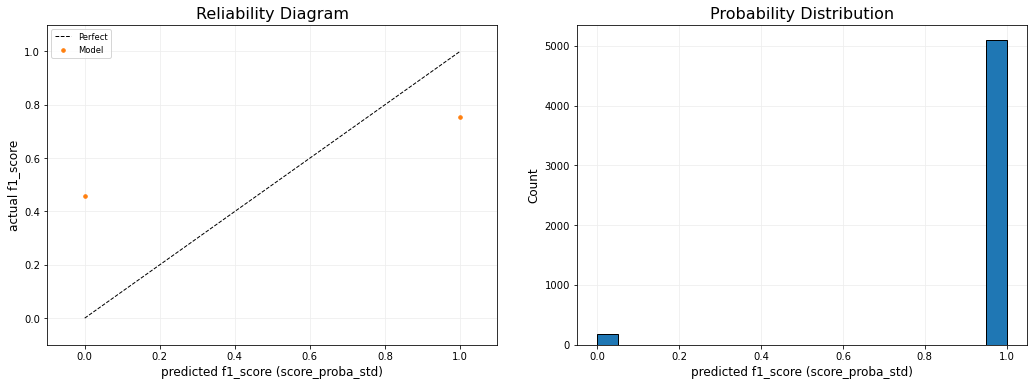

In [31]:
X_calib, y_calib, models = next(train_evaluations)


# Before calibration
uncalib_global_metrics = y_calib.join(X_calib, how="left")
uncalib_corr_metrics, uncalib_calib_metrics = evaluate_metrics(
    global_metrics=uncalib_global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)


# After calibration
preds_df = pd.DataFrame(models)
preds_df.index = y_calib.index

global_metrics = y_calib.join(preds_df, how="left")
calib_corr_metrics, calib_calib_metrics = evaluate_metrics(
    global_metrics=global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)

In [32]:
uncalib_global_metrics.describe()

,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,...,bleu_2,bleu_3,bleu_4,preds_raw_count,truncated,score_proba,score_proba_arithm,score_proba_std,score_proba_geom,score_proba_hmean
count,5282.000000,2184.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,...,5282.000000,5282.000000,5282.000000,5282.000000,5282.0,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.586520,0.537546,0.740409,0.802170,0.744901,0.706916,0.747225,0.412669,0.747082,0.747082,...,0.531490,0.283627,0.157540,4.876562,1.0,0.664610,0.919063,0.096028,0.907865,0.894710
std,0.492504,1.237474,0.384534,0.373358,0.369950,0.390080,0.368251,0.465121,0.368451,0.368451,...,0.486545,0.442328,0.357713,4.487216,0.0,0.260956,0.079358,0.076684,0.092796,0.109074
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,1.0,0.000154,0.222982,0.000000,0.217411,0.204678
25%,0.000000,0.000000,0.500000,1.000000,0.571429,0.400000,0.571429,0.000000,0.571429,0.571429,...,0.000000,0.000000,0.000000,2.000000,1.0,0.471652,0.887158,0.027078,0.869804,0.849316
50%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,3.000000,1.0,0.708010,0.940675,0.084265,0.934479,0.928095
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,0.000000,6.000000,1.0,0.903753,0.976909,0.152690,0.975936,0.975318
max,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,51.000000,1.0,0.999623,0.999811,0.433899,0.999811,0.999811


In [33]:
global_metrics.describe()

,exact_match,first_error_position,precision,recall,f1_score,csi,rouge1,rouge2,rougeL,rougeLsum,...,reference_length,bleu_1,bleu_2,bleu_3,bleu_4,score_proba,score_proba_arithm,score_proba_geom,score_proba_hmean,score_proba_std
count,5282.000000,2184.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,...,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000,5282.000000
mean,0.586520,0.537546,0.740409,0.802170,0.744901,0.706916,0.747225,0.412669,0.747082,0.747082,...,2.123627,0.852039,0.531490,0.283627,0.157540,0.926732,0.971412,0.967437,0.961568,0.964975
std,0.492504,1.237474,0.384534,0.373358,0.369950,0.390080,0.368251,0.465121,0.368451,0.368451,...,1.677472,0.322502,0.486545,0.442328,0.357713,0.260600,0.166660,0.177508,0.192256,0.183859
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.500000,1.000000,0.571429,0.400000,0.571429,0.000000,0.571429,0.571429,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,2.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,3.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,1.000000,11.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,18.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Uncalibrated metrics

In [34]:
# Regarding the uncalibrated dataset
uncalib_corr_metrics

,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.374670,1.092568e-175,0.401967,2.386091e-204,0.305464,1.044091e-191,correlation
1,f1_score,score_proba_arithm,0.261688,1.943691e-83,0.282335,2.219937e-97,0.215888,9.323163e-97,correlation
2,f1_score,score_proba_geom,0.278507,1.057089e-94,0.293955,9.027479e-106,0.224851,8.574598e-105,correlation
3,f1_score,score_proba_hmean,0.293350,2.524796e-105,0.304555,8.917295e-114,0.232925,2.603184e-112,correlation
4,f1_score,score_proba_std,-0.311640,2.571680e-119,-0.330204,1.425807e-134,-0.252936,4.399325e-132,correlation


In [35]:
calib_corr_metrics

,x,y,pearsonr,pearsonr_pvalue,spearmanr,spearmanr_pvalue,kendall_tau,kendall_tau_pvalue,metric_type
0,f1_score,score_proba,0.256155,6.584816e-80,0.255126,2.924179e-79,0.234824,9.801515e-77,correlation
1,f1_score,score_proba_arithm,0.115715,3.277582e-17,0.100421,2.571827e-13,0.092430,2.928519e-13,correlation
2,f1_score,score_proba_geom,0.145191,2.798469e-26,0.126274,3.202442e-20,0.116225,4.459002e-20,correlation
3,f1_score,score_proba_hmean,0.170411,1.042786e-35,0.149105,1.218352e-27,0.137240,2.335978e-27,correlation
4,f1_score,score_proba_std,0.148642,1.773152e-27,0.129050,4.677129e-21,0.118781,6.715051e-21,correlation


In [36]:
uncalib_calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.139041,0.285482,-0.080290,0.364135,0.117291,0.012374,0.116924,0.026810,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.158104,0.252637,0.174162,0.357451,0.174162,0.061162,0.174162,0.021553,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.152885,0.251094,0.162964,0.355427,0.162964,0.055608,0.162964,0.021283,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.147505,0.249467,0.149809,0.353641,0.149809,0.050086,0.149809,0.020444,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.581430,0.690834,-0.648872,0.400494,0.650157,0.311840,0.649191,0.090917,"{'n_bins': 20, 'frac': 0.1}",calibration


In [37]:
calib_calib_metrics

,x,y,mse,mae,ce_avg,ce_std,ECE_eq_width,ECE_eq_width_max,ECE_eq_freq,ECE_eq_freq_max,hyperparams,metric_type
0,f1_score,score_proba,0.188417,0.241604,0.181832,0.394151,0.029886,0.029886,0.229213,0.024956,"{'n_bins': 20, 'frac': 0.1}",calibration
1,f1_score,score_proba_arithm,0.201649,0.254835,0.226512,0.387739,0.014162,0.014162,0.226512,0.028020,"{'n_bins': 20, 'frac': 0.1}",calibration
2,f1_score,score_proba_geom,0.198797,0.251983,0.222536,0.386361,0.014724,0.014724,0.222536,0.026947,"{'n_bins': 20, 'frac': 0.1}",calibration
3,f1_score,score_proba_hmean,0.196501,0.249687,0.216667,0.386725,0.016510,0.016510,0.221748,0.027201,"{'n_bins': 20, 'frac': 0.1}",calibration
4,f1_score,score_proba_std,0.198851,0.252037,0.220075,0.387838,0.015981,0.015981,0.221132,0.027518,"{'n_bins': 20, 'frac': 0.1}",calibration


### Calib metrics

In [38]:
### Test evaluations



# -------------------------------------------------------------------------------------------------------------- #
#			 squad (validation) ---> squad (validation)
# -------------------------------------------------------------------------------------------------------------- #
Loading predictions from ../outputs/results/squad/validation/calib/matrix/test_squad_validation_scores.csv.gz
Loading evaluation metrics from ../outputs/results/squad/validation/calib/matrix/test_squad_validation_evals_default.csv.gz
Considering features: None
Considering target: None
Evaluate in training set for dataset: squad validation
score_proba test_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at test_squad_validation_score_proba_jointplot.svg
Saved figure at test_squad_validation_score_proba_reliability.svg
score_proba_arithm test_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at test_squad_validation_score_proba_arithm_jointplot.svg
Saved figure at test_squad_validation_score_proba_arithm_reliability.svg
score_proba_geom test_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at test_squad_validation_score_proba_geom_jointplot.svg
Saved figure at test_squad_validation_score_proba_geom_reliability.svg
score_proba_hmean test_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at test_squad_validation_score_proba_hmean_jointplot.svg
Saved figure at test_squad_validation_score_proba_hmean_reliability.svg
score_proba_std test_squad_validation


/home/kat/miniconda3/envs/py39-pytorch/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Saved figure at test_squad_validation_score_proba_std_jointplot.svg
Saved figure at test_squad_validation_score_proba_std_reliability.svg
score_proba
score_proba_arithm
score_proba_geom
score_proba_hmean
score_proba_std


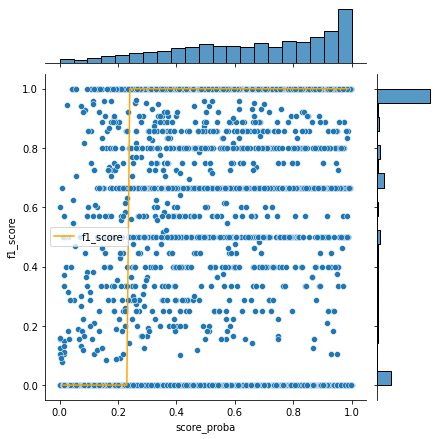

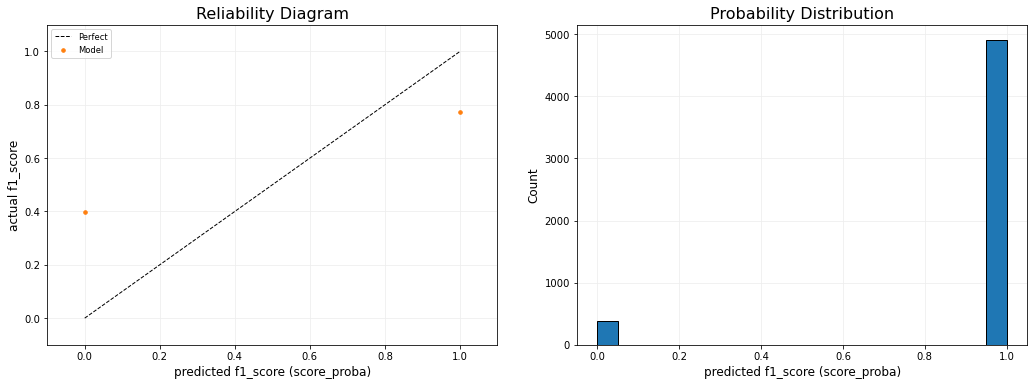

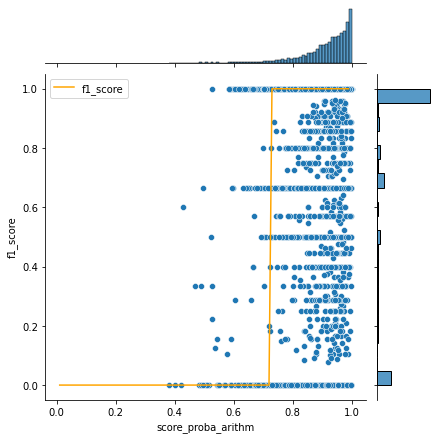

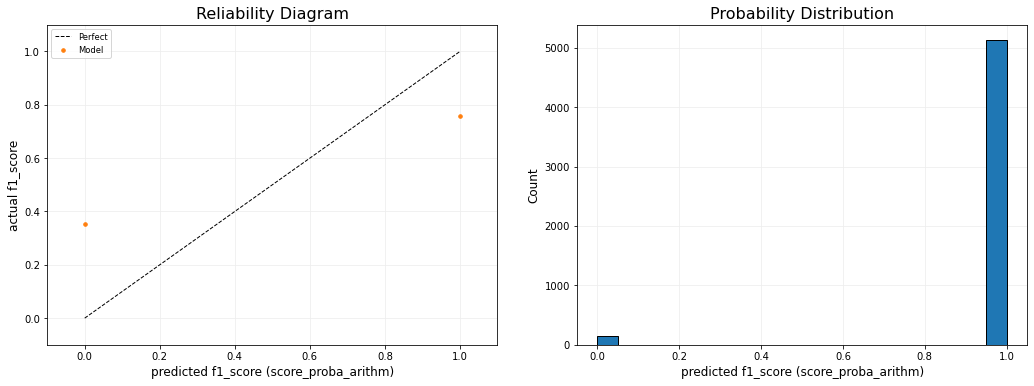

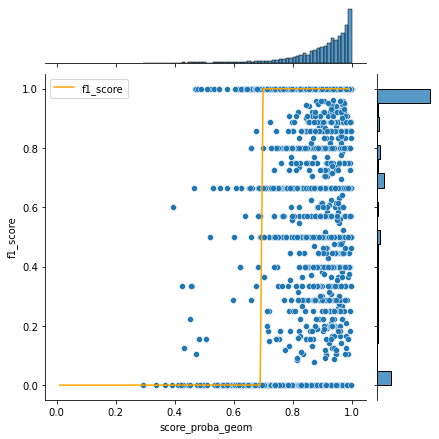

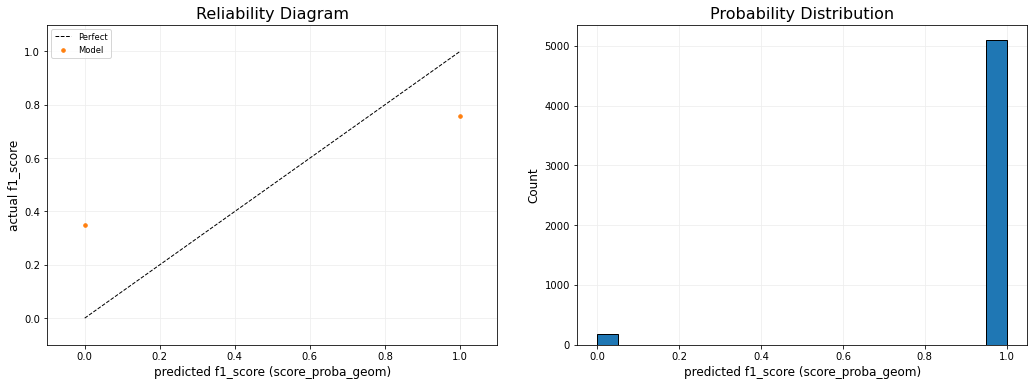

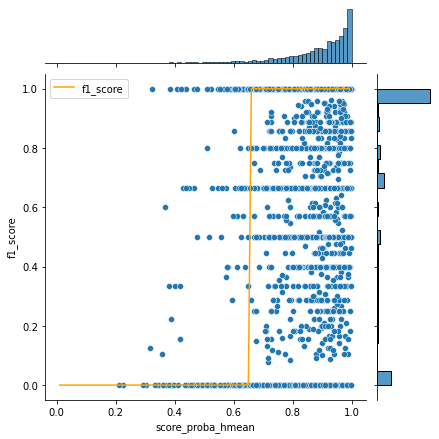

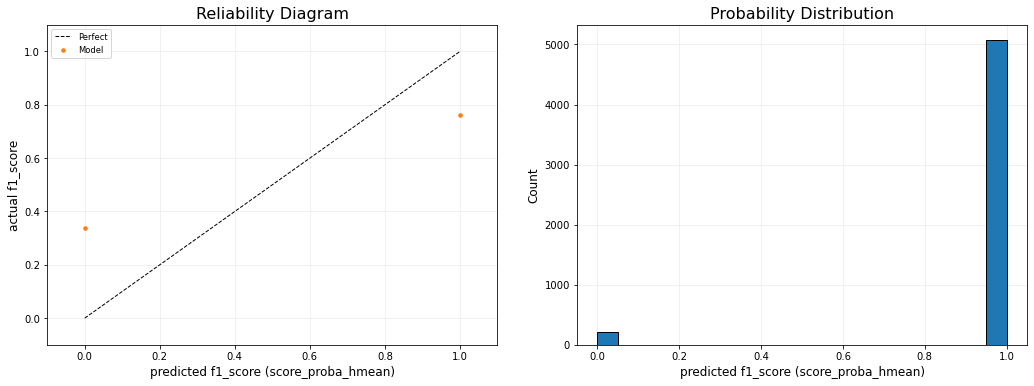

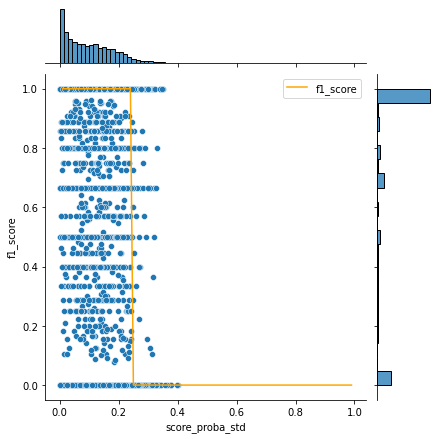

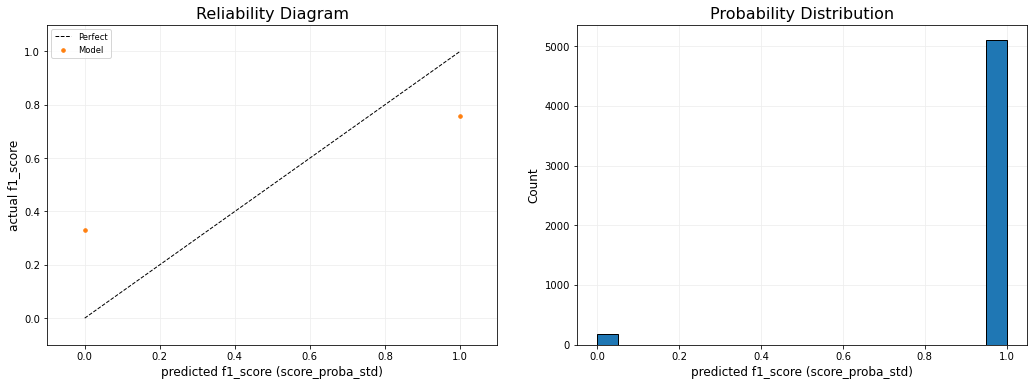

In [39]:
X, y, models = next(test_evaluations)

preds_df = pd.DataFrame(models)
preds_df.index = y.index

global_metrics = y.join(preds_df, how="left")
corr_metrics, calib_metrics = evaluate_metrics(
    global_metrics=global_metrics,
    score_cols=UNCALIBRATED_SCORE_COLS,
)